## Kalman Filter Model


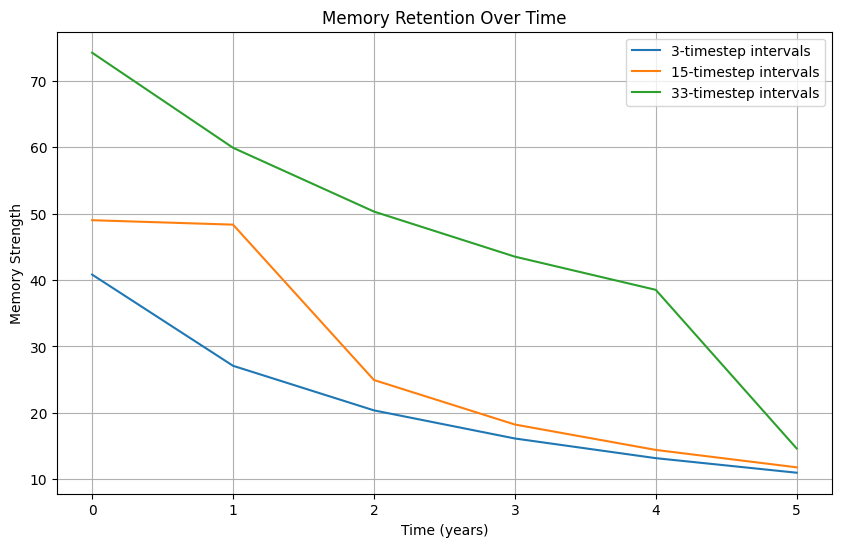

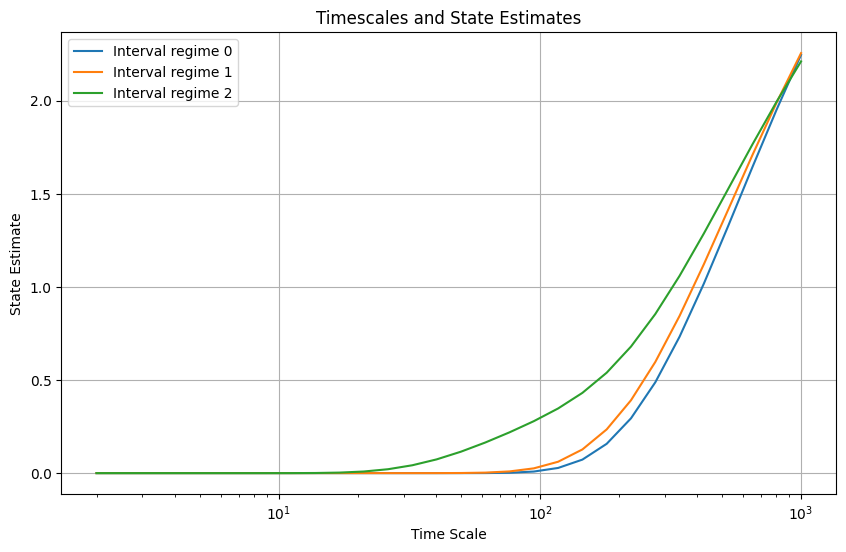

In [81]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:

  def __init__(self, num_timescales=30, sigma_w=0.05, c=0.001):
    self.n = num_timescales
    # Initialize state estimates as zeroes
    self.states = np.zeros(self.n)
    # Initialize prior covariances/uncertainty about system
    self.covariance_estimates = np.eye(self.n)

    # Measurement noise
    self.sigma_w = sigma_w
    # Distance variance factor (c)
    self.c = c

    # Exponentially increasing timescales
    self.timescales = np.logspace(np.log10(2), np.log10(1000), num_timescales)

    # State noise matrix, smaller timescales -> noisier
    self.Q = np.diag([self.c / tau for tau in self.timescales])

    # Observation matrix
    self.H = np.ones((1, self.n))

  def predict(self):
    # State decay based on timescale, smaller timescales -> larger decay
    for i, tau in enumerate(self.timescales):
      self.states[i] *= 1 - 1 / tau
    self.covariance_estimates += self.Q

  def update(self, observation):
      # Measurement matrix
      H = self.H
      # Measurement noise covariance
      R = np.eye(H.shape[0]) * self.sigma_w  # Assuming R is proportional to an identity matrix scaled by sigma_w

      # Compute the Kalman Gain
      S = H @ self.covariance_estimates @ H.T + R  # Innovation (or residual) covariance
      K = self.covariance_estimates @ H.T @ np.linalg.inv(S)  # Kalman Gain

      # Update the estimate
      y = observation - H @ self.states  # Observation residual
      self.states += K @ y  # Update state estimate with Kalman Gain weighted residual

      # Update the state covariance
      I = np.eye(self.n)  # Identity matrix matching the dimension of the state vector
      self.covariance_estimates = (I - K @ H) @ self.covariance_estimates

  # def update(self, observation):
  #   # Compute Kalman gain
  #   K_num = np.dot(self.covariance_estimates, self.H.T)
  #   K_denom = np.dot(np.dot(self.H, self.covariance_estimates), self.H.T) + self.sigma_w
  #   K = K_num / K_denom

  #   error = observation - np.dot(self.H, self.states)
  #   self.states += np.dot(K, error).flatten()
  #   self.covariance_estimates = np.dot((np.eye(self.n) - np.dot(K, self.H)), self.covariance_estimates)

  def compute_motor_gain(self):
    return 1 + np.sum(self.states)

  def lesion(self, num_lesion):
    self.states[:num_lesion] = 0
    # self.covariance_estimates[:num_lesion, :num_lesion] = np.eye(10) * 99999
    self.Q = np.diag([self.c / tau if i > 10 else self.c * 99999 / tau for i, tau in enumerate(self.timescales)])

# Parameters
n_timescales = 30
observation_noise_variance = 1
disturbance_variance_factor = 0.03
n_steps_per_year = 100
n_years = 5
intervals = [3, 15, 33]
epochs = 30

# Initialize the filter

# Simulate learning trials and periods of no observation
memory_strength_over_time = {interval : [0, 0, 0, 0, 0, 0] for interval in intervals}

mkf = KalmanFilter(num_timescales = 30, sigma_w = 1, c = 0.03)
timescales = []
states = []
np.random.seed(1401)
for interval in intervals:
  mkf = KalmanFilter(num_timescales = 30, sigma_w = 1, c = 0.03)
  sessions = 15
  day = 0
  for year in range(n_years + 1):
      for step in range(n_steps_per_year):
          day += 1
          mkf.predict()
          if day % interval == 0 and sessions > 0:  # Simulate a learning event at each time interval
              mkf.update(100)
              sessions -= 1
      memory_strength_over_time[interval][year] = mkf.compute_motor_gain()
  timescales.append(mkf.timescales)
  states.append(mkf.states)

# Plotting the retention function
plt.figure(figsize=(10, 6))
for interval in intervals:
  plt.plot(np.linspace(0, n_years, n_years + 1), memory_strength_over_time[interval], label=f"{interval}-timestep intervals")
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Memory Strength')
plt.title('Memory Retention Over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for i in range(3):
  plt.plot(timescales[i], states[i], label=f"Interval regime {i}")
plt.xscale('log')
plt.xlabel('Time Scale')
plt.ylabel('State Estimate')
plt.legend()
plt.title('Timescales and State Estimates')
plt.grid(True)
plt.show()

## Temporal Gradient Retrograde Amnesia

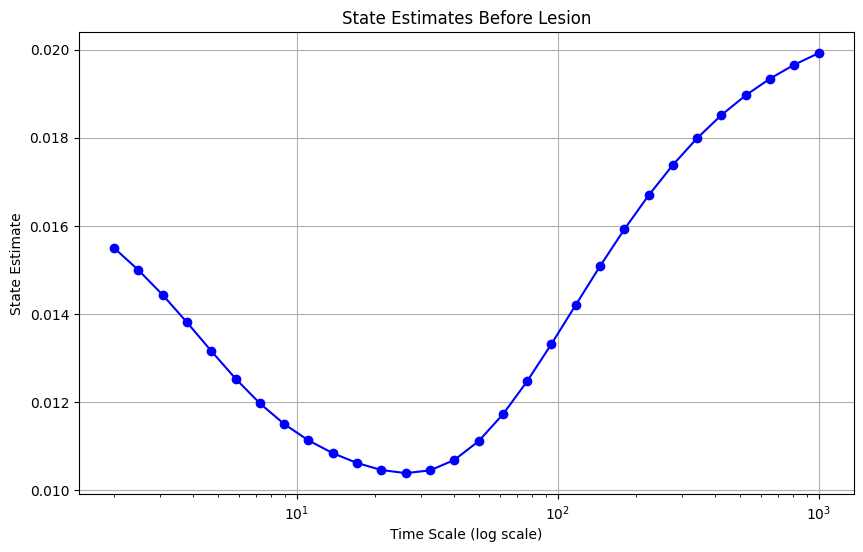

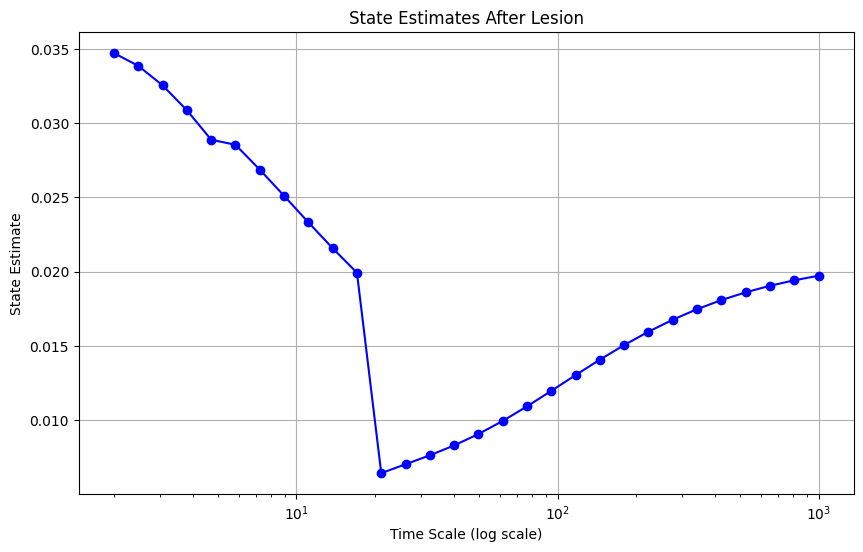

In [84]:
# Initialize the Kalman Filter
kf = KalmanFilter()

# Number of observations (e.g., simulating learning over time)
num_observations = 100
observations = np.random.normal(loc=0.5, scale=0.1, size=num_observations)

# Update the Kalman Filter with each observation to simulate learning
for obs in observations:
    kf.predict()
    kf.update(obs)

plt.figure(figsize=(10, 6))
plt.plot(kf.timescales, kf.states, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Time Scale (log scale)')
plt.ylabel('State Estimate')
plt.title('State Estimates Before Lesion')
plt.grid(True)
plt.show()

# Number of observations (e.g., simulating learning over time)
num_observations = 10
observations = np.random.normal(loc=0.5, scale=0.1, size=num_observations)

# Perform lesioning by reducing efficacy of short-term timescale
kf.lesion(5)
for obs in observations:
    kf.predict()
    kf.update(obs)

plt.figure(figsize=(10, 6))
plt.plot(kf.timescales, kf.states, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Time Scale (log scale)')
plt.ylabel('State Estimate')
plt.title('State Estimates After Lesion')
plt.grid(True)
plt.show()


[ 1.          6.44444444 11.88888889 17.33333333 22.77777778 28.22222222
 33.66666667 39.11111111 44.55555556 50.        ]


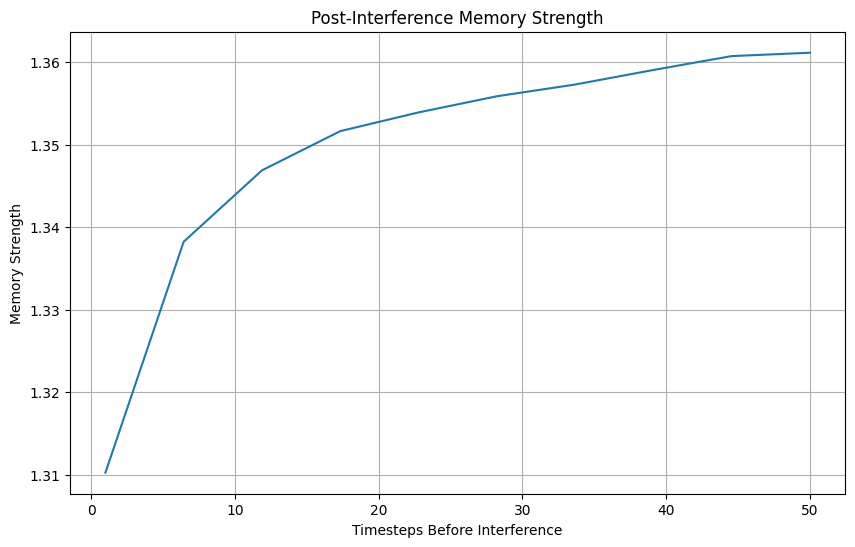

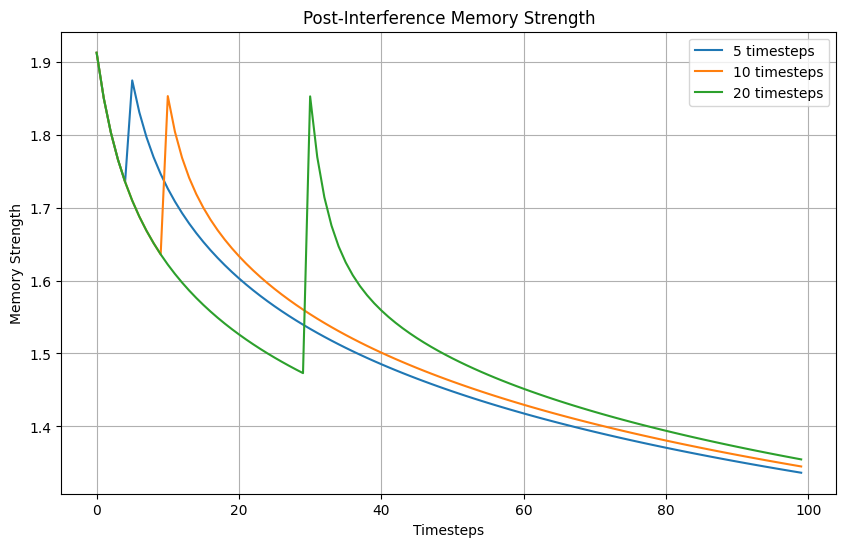

In [112]:
spacing = np.linspace(1, 50, 10)
print(spacing)
yval = []
total = 100
for space in spacing:
  kf=KalmanFilter()
  kf.update(1)
  for _ in range(int(space)):
    kf.predict()
  kf.update(1)
  for _ in range(int(total - space)):
    kf.predict()
  yval.append(kf.compute_motor_gain())

plt.figure(figsize=(10, 6))
plt.plot(spacing, yval)
plt.xlabel('Timesteps Before Interference')
plt.ylabel('Memory Strength')
plt.title('Post-Interference Memory Strength')
plt.grid(True)
plt.show()

kf = KalmanFilter()
kf.update(1)
strength1 = []
strength2 = []
strength3 = []
for i in range(100):
  kf.predict()
  if i == 5:
    kf.update(1)
  strength1.append(kf.compute_motor_gain())

kf = KalmanFilter()
kf.update(1)
for i in range(100):
  kf.predict()
  if i == 10:
    kf.update(1)
  strength2.append(kf.compute_motor_gain())

kf = KalmanFilter()
kf.update(1)
for i in range(100):
  kf.predict()
  if i == 30:
    kf.update(1)
  strength3.append(kf.compute_motor_gain())

plt.figure(figsize=(10, 6))
plt.plot(range(100), strength1, label="5 timesteps")
plt.plot(range(100), strength2, label="10 timesteps")
plt.plot(range(100), strength3, label="20 timesteps")
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Memory Strength')
plt.title('Post-Interference Memory Strength')
plt.grid(True)
plt.show()
